In [506]:
import pandas as pd
import numpy as np
import random
from collections import Counter
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, anderson, kstest
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error
import json
import os
import shutil

## User inputs from GUI

In [507]:

assets_folder = "metadata"
json_file_path_user_ip = os.path.join(assets_folder, "user_inputs.json")
with open(json_file_path_user_ip, 'r') as f:
    user_inputs = json.load(f)

assets_folder = "metadata"
json_file_path_user_dtype = os.path.join(assets_folder, "user_data_types.json")
with open(json_file_path_user_dtype, 'r') as f:
    user_data_types = json.load(f)
    
assets_folder = "data"
csv_file_path_raw = os.path.join(assets_folder, "df_raw.csv")
df_raw = pd.read_csv(csv_file_path_raw)

In [508]:
user_inputs

{'Target Column': 'Class variable',
 'Remove Features': 'None',
 'Ordinal Degree': [],
 'Binning Columns': 'None',
 'Training Data Size': '70%',
 'K-Fold': '5',
 'Machine Learning Task': 'Classification',
 'Data Types': {'Number of times pregnant': 'integer dtype',
  'Plasma glucose concentration': 'int64',
  'Diastolic blood pressure (mm Hg)': 'int64',
  'Triceps skin fold thickness (mm)': 'int64',
  '2-Hour serum insulin (mu U/ml)': 'int64',
  'Body mass index (weight in kg/(height in m)^2)': 'float64',
  'Diabetes pedigree function': 'float64',
  'Age (years)': 'int64',
  'Class variable': 'int64'}}

In [509]:
preprocessing_report_inputs = {}
preprocessing_report_inputs['raw_shape'] = df_raw.shape
preprocessing_report_inputs['raw_dtype'] = df_raw.dtypes.to_dict()

In [510]:
preprocessing_report_inputs

{'raw_shape': (768, 9),
 'raw_dtype': {'Number of times pregnant': dtype('int64'),
  'Plasma glucose concentration': dtype('int64'),
  'Diastolic blood pressure (mm Hg)': dtype('int64'),
  'Triceps skin fold thickness (mm)': dtype('int64'),
  '2-Hour serum insulin (mu U/ml)': dtype('int64'),
  'Body mass index (weight in kg/(height in m)^2)': dtype('float64'),
  'Diabetes pedigree function': dtype('float64'),
  'Age (years)': dtype('int64'),
  'Class variable': dtype('int64')}}

## Feature removal as per user Input

In [511]:
if (user_inputs['Remove Features'] != 'None'):
    df_raw = df_raw.drop(columns=[user_inputs['Remove Features']])

In [512]:
dtype_options = ["integer dtype", "float dtype", "Categorical(Ordinal)", "Categorical(Nominal)", "string", "object dtype","Datetime dtype"]

## Date Type Constraints

In [513]:
# This Fx is used for convert the dtype based on user input
def convert_data_types(df, dtype_dict):
    """Converts the columns in df based on dtype_dict."""
    for column, dtype_str in dtype_dict.items():
        if column in df.columns:
            # Apply the conversion based on dtype_str
            if dtype_str == "integer dtype":
                df[column] = df[column].astype(np.int64)
            elif dtype_str == "float dtype":
                df[column] = df[column].astype(np.float64)
            elif dtype_str == "Categorical(Ordinal)" or dtype_str == "Categorical(Nominal)":
                df[column] = df[column].astype('category')
            elif dtype_str == "string":
                df[column] = df[column].astype(str)
            elif dtype_str == "object dtype":
                df[column] = df[column].astype(object)
            elif dtype_str == "Datetime dtype":
                df[column] = pd.to_datetime(df[column], errors='coerce')
    return df


# This fx is used when user not selected any of the dtypes.
def detect_value_type(value):
    """Classifies a value into one of the possible data types."""
    if isinstance(value, bool) or str(value).lower() in ['true', 'false']:
        return 'bool'
    if str(value).lstrip('-').isdigit():
        return 'int'
    try:
        float(value)
        return 'float'
    except ValueError:
        pass
    try:
        pd.to_datetime(value)
        return 'datetime'
    except (ValueError, TypeError):
        pass
    return 'string'

def infer_column_dtype(series, sample_size=10):
    """Infer the best possible dtype for a Pandas Series using voting from a sample."""
    sample_values = series.dropna().sample(min(sample_size, len(series)), random_state=42).astype(str)
    type_counts = Counter(detect_value_type(val) for val in sample_values)

    # Determine the most common type
    most_common_type = type_counts.most_common(1)[0][0]
    return most_common_type

def auto_convert_types_with_voting(df, sample_size=10):
    """Automatically detect and convert column types using majority voting from a random sample."""
    inferred_types = {col: infer_column_dtype(df[col], sample_size) for col in df.columns}

    for col, dtype in inferred_types.items():
        if dtype == 'int':
            df[col] = pd.to_numeric(df[col], errors='coerce', downcast='integer')
        elif dtype == 'float':
            df[col] = pd.to_numeric(df[col], errors='coerce')
        elif dtype == 'bool':
            df[col] = df[col].map(lambda x: str(x).strip().lower() in ['true', '1', 'yes', 'on'])
        elif dtype == 'datetime':
            df[col] = pd.to_datetime(df[col],infer_datetime_format=True, errors='coerce')
        else:
            df[col] = df[col].astype('string')

    return df, inferred_types

# Main Logic

user_dtype_list = []
for i in user_data_types.items():
    user_dtype_list.append(i[1])
if (pd.Series(user_dtype_list).isin(dtype_options).sum() == 0):
    print(f'Before DataType Assignment: {df_raw.dtypes}')
    df_dtype_converted, inferred_types = auto_convert_types_with_voting(df_raw)
    print("After Inferred Types:", inferred_types)
    print(df_dtype_converted.dtypes)
    print(df_dtype_converted)
else:
    df_dtype_converted = convert_data_types(df_raw, user_data_types)
    print(df_dtype_converted.dtypes)

Number of times pregnant                            int64
Plasma glucose concentration                        int64
Diastolic blood pressure (mm Hg)                    int64
Triceps skin fold thickness (mm)                    int64
2-Hour serum insulin (mu U/ml)                      int64
Body mass index (weight in kg/(height in m)^2)    float64
Diabetes pedigree function                        float64
Age (years)                                         int64
Class variable                                      int64
dtype: object


In [514]:

#df_dtype_converted.to_pickle('df_dtype_converted.pkl') # Report

## Uniqueness constraints To Remove duplicate Rows

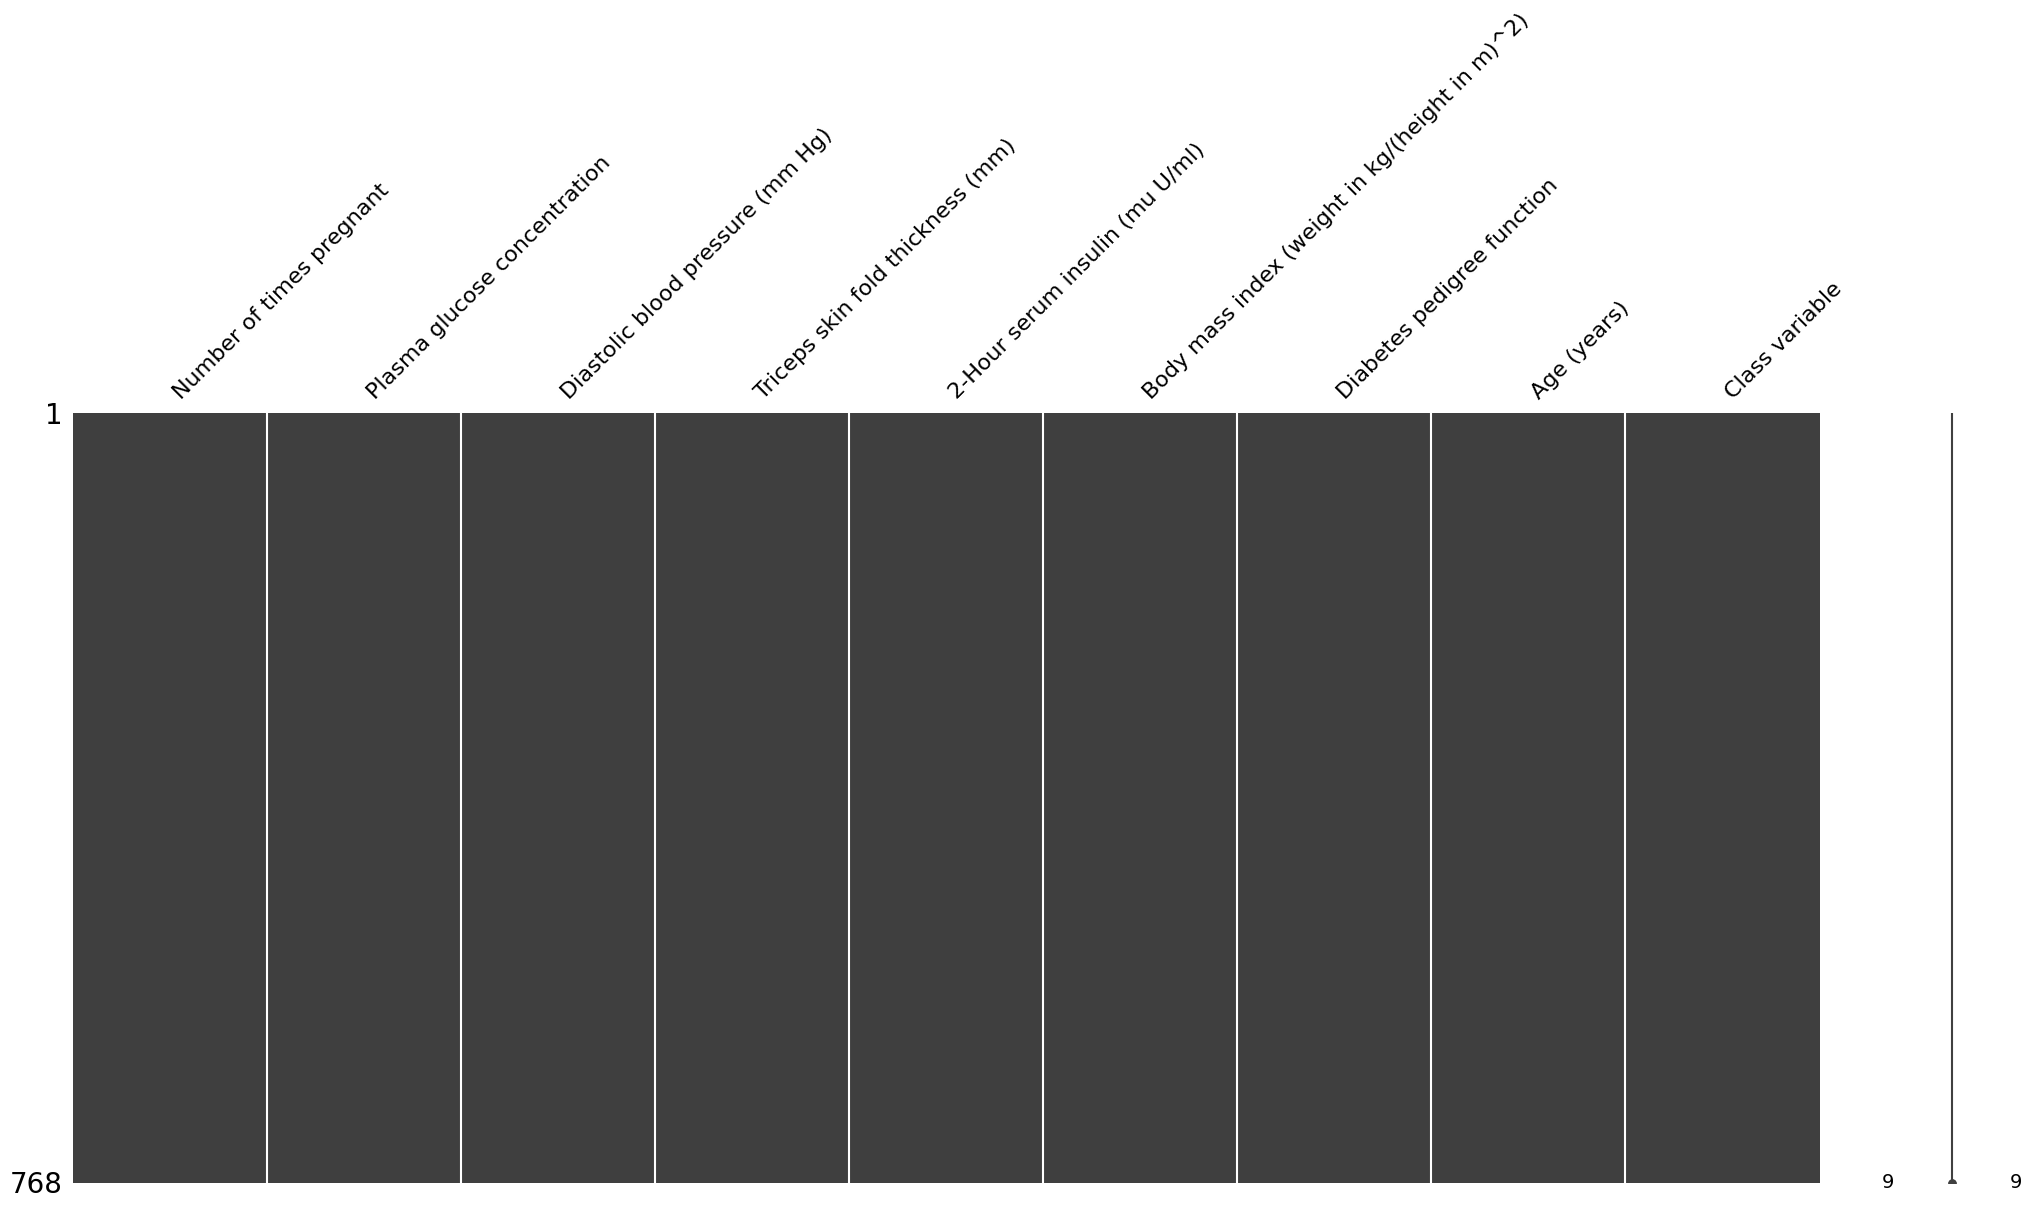

Data Frame Shape(Before):(768, 9)
Data Frame Shape(After):(768, 9)


In [515]:
# Remove row duplicates
df_dtype_converted = df_dtype_converted.drop_duplicates()
row_duplicate_shape = df_dtype_converted.shape # Report
preprocessing_report_inputs['Remove_duplicate_shape'] = row_duplicate_shape
# plot NA 
msno.matrix(df_dtype_converted)
plt.show()

# Remove columns with 70% of missing data
threshold = 0.7  # Set threshold (70%)
print(f'Data Frame Shape(Before):{df_dtype_converted.shape}')
missing_ratio = df_dtype_converted.isnull().mean()  # Calculate missing percentage
cols_to_drop = missing_ratio[missing_ratio >= threshold].index 
df_dtype_converted = df_dtype_converted.drop(columns=cols_to_drop) 
col_drop_70_na = df_dtype_converted.shape # report
na_summary = df_dtype_converted.isna().sum().to_dict() # report
preprocessing_report_inputs['col_drop_70_na'] = col_drop_70_na
preprocessing_report_inputs['na_summary'] = na_summary
print(f'Data Frame Shape(After):{df_dtype_converted.shape}')

## Save pickel file for next stage

In [516]:
assets_folder = "data"
os.makedirs(assets_folder, exist_ok=True)
pkl_file_path_raw = os.path.join(assets_folder, "df_dtype_converted.pkl")
df_dtype_converted.to_pickle(pkl_file_path_raw)

In [517]:
print(row_duplicate_shape)
print(col_drop_70_na)
na_summary 

(768, 9)
(768, 9)


{'Number of times pregnant': 0,
 'Plasma glucose concentration': 0,
 'Diastolic blood pressure (mm Hg)': 0,
 'Triceps skin fold thickness (mm)': 0,
 '2-Hour serum insulin (mu U/ml)': 0,
 'Body mass index (weight in kg/(height in m)^2)': 0,
 'Diabetes pedigree function': 0,
 'Age (years)': 0,
 'Class variable': 0}

## Find best Imputation Method for numerical features

In [518]:

def imput_finder(df):

# Copy the dataset to introduce artificial missing values for testing
    df_test = df.copy()

    # Identify columns with missing values
    missing_cols = df.columns[df.isnull().any()].tolist()

    # Store the original non-missing values for later comparison
    true_values = {}
    for col in missing_cols:
        true_values[col] = df_test[col].dropna().sample(frac=0.3, random_state=42)  # Remove 30% of known values

    # Introduce artificial missing values
    for col in missing_cols:
        df_test.loc[true_values[col].index, col] = np.nan

    # Mean Imputation
    mean_imputer = SimpleImputer(strategy="mean")
    df_mean = df_test.copy()
    df_mean[missing_cols] = mean_imputer.fit_transform(df_mean[missing_cols])

    # Median Imputation
    median_imputer = SimpleImputer(strategy="median")
    df_median = df_test.copy()
    df_median[missing_cols] = median_imputer.fit_transform(df_median[missing_cols])

    # Mode (Most Frequent) Imputation
    mode_imputer = SimpleImputer(strategy="most_frequent")
    df_mode = df_test.copy()
    df_mode[missing_cols] = mode_imputer.fit_transform(df_mode[missing_cols])

    # KNN Imputation
    knn_imputer = KNNImputer(n_neighbors=5)
    df_knn = df_test.copy()
    df_knn[missing_cols] = knn_imputer.fit_transform(df_knn[missing_cols])

    def calculate_rmse(original_values, imputed_values):
        return np.sqrt(mean_squared_error(original_values, imputed_values))

    rmse_scores = {}

    for col in missing_cols:
        rmse_scores[col] = {
            "mean": calculate_rmse(true_values[col], df_mean.loc[true_values[col].index, col]),
            "median": calculate_rmse(true_values[col], df_median.loc[true_values[col].index, col]),
            "mode": calculate_rmse(true_values[col], df_mode.loc[true_values[col].index, col]),
            "knn": calculate_rmse(true_values[col], df_knn.loc[true_values[col].index, col]),
        }

    # Print RMSE scores for each column
    #for col, scores in rmse_scores.items():
    #    print(f"Column: {col}")
    #    for method, rmse in scores.items():
    #        print(f"  {method} Imputation: RMSE = {rmse:.4f}")
    #    print("\n")
        
    # Aggregate RMSE scores by averaging across all columns
    method_avg_rmse = {}

    for method in ["mean", "median", "mode", "knn"]:
        method_avg_rmse[method] = np.mean([scores[method] for scores in rmse_scores.values()])

    # Print average RMSE for each method
    print("Average RMSE for each imputation method:")
    for method, avg_rmse in method_avg_rmse.items():
        print(f"{method}: {avg_rmse:.4f}")
        
    imputation_method_best = min(method_avg_rmse, key=method_avg_rmse.get)
    
    method_avg_rmse_met = pd.DataFrame({'Imputation Method': method_avg_rmse.keys(),
    'RMSE':method_avg_rmse.values()})
    imput_plot = sns.barplot(data = method_avg_rmse_met,x='Imputation Method', y='RMSE',hue = 'Imputation Method',palette='viridis')
    plt.xlabel('Imputataion Method')
    plt.ylabel('RMSE')
    plt.title('Comparision of imputation Methods')
    plt.show()
    
    return imputation_method_best,imput_plot,method_avg_rmse_met


if df_dtype_converted.select_dtypes(include = 'number').isna().any().any(): 
    imput_method, plot,method_avg_rmse_met = imput_finder(df_dtype_converted.select_dtypes(include = 'number'))
    preprocessing_report_inputs['impute_graph_data'] = method_avg_rmse_met
    preprocessing_report_inputs['impute_method'] = imput_method
else:
    imput_method = 'mean'
    preprocessing_report_inputs['impute_graph_data'] = None
    preprocessing_report_inputs['impute_method'] = imput_method
    

Method	Checks	When to Normalize?
- Standard Deviation Check	Measures spread of features	If max(std) / min(std) > 10
- Feature Range Check	Checks max - min difference	If max(range) / min(range) > 10
- Mean/Std Ratio Check	Identifies inconsistent feature distributions	If max(mean/std) / min(mean/std) > 10

## Normalization and transformation Check

In [519]:

def norm_transform_check(df_new):
    # Check if normalization is needed
    feature_std = df_new.select_dtypes(include='number').std()
    feature_ranges = df_new.select_dtypes(include='number').apply(lambda x: x.max() - x.min())
    feature_means = df_new.select_dtypes(include='number').mean()

    # Compute scale ratios
    scale_ratio = feature_std.max() / feature_std.min()
    range_ratio = feature_ranges.max() / feature_ranges.min()
    mean_std_ratio = feature_means.max() / feature_means.min()

    # Check if any criteria indicate scale differences
    normalization_req = scale_ratio > 10 or range_ratio > 10 or mean_std_ratio > 10

    print(f"Feature Scale Ratio: {scale_ratio}")
    print(f"Feature Range Ratio: {range_ratio}")
    print(f"Feature Mean/Std Ratio: {mean_std_ratio}")
    print(f"Normalization Needed: {normalization_req}")
    
    norm_report = {'scale_ratio' : scale_ratio,
                   'range_ratio' : range_ratio,
                   'mean_std_ratio' : mean_std_ratio}
    
    # Check if transformation is needed
    transformation = []
    for col in df_new.select_dtypes(include='number').columns:
        data = df_new[col]

        if len(data) <= 5000:  # Small dataset, use Shapiro-Wilk test
            stat, p = shapiro(data)
            print(f"{col}: Shapiro-Wilk Test Statistic={stat}, p-value={p}")
            transformation.append(p <= 0.05) 
            transform_report = {'Shapiro-Wilk Test Statistic' : stat,
                                'Shapiro-Wilk Test p-value' : p}
            # True means transformation is needed
        else:  # Larger dataset, use Anderson-Darling or Kolmogorov-Smirnov test
            # Anderson-Darling test
            result = anderson(data, dist='norm')
            print(f"{col}: Anderson-Darling Test Statistic={result.statistic}, p-value={result.significance_level}")
            transform_report = {
                'Anderson-Darling Test Statistic' : result.statistic,
                'Anderson-Darling Test p-value' : result.significance_level
            }
            if result.statistic > result.critical_values[2]:  # If the statistic is greater than the 5% critical value
                transformation.append(True)
            else:
                transformation.append(False)
            
            # Alternatively, you can use Kolmogorov-Smirnov test:
            # ks_stat, ks_p = kstest(data, 'norm')
            # print(f"{col}: KS Test Statistic={ks_stat}, p-value={ks_p}")
            # transformation.append(ks_p <= 0.05)

    # Determine whether transformation is needed based on majority vote
    transformation_vote = sum(transformation) > len(transformation) / 2
    transformation_req = transformation_vote  # True if majority of features require transformation

    print(f"Normalization Required: {normalization_req}")
    print(f"Transformation Required: {transformation_req}")
    
    return transformation_req,normalization_req,norm_report,transform_report

transformation_req , normalization_req , norm_report,transform_report = norm_transform_check(df_dtype_converted.drop(columns=[user_inputs['Target Column']]))

preprocessing_report_inputs['norm_report'] = norm_report
preprocessing_report_inputs['transform_report'] = transform_report


Feature Scale Ratio: 347.823894725702
Feature Range Ratio: 361.22971818958155
Feature Mean/Std Ratio: 256.1996241732225
Normalization Needed: True
Number of times pregnant: Shapiro-Wilk Test Statistic=0.9042829871177673, p-value=1.6099220776076377e-21
Plasma glucose concentration: Shapiro-Wilk Test Statistic=0.9701048731803894, p-value=1.9874457982127502e-11
Diastolic blood pressure (mm Hg): Shapiro-Wilk Test Statistic=0.8189232349395752, p-value=1.584460037464327e-28
Triceps skin fold thickness (mm): Shapiro-Wilk Test Statistic=0.9046282172203064, p-value=1.75197520168424e-21
2-Hour serum insulin (mu U/ml): Shapiro-Wilk Test Statistic=0.7220207452774048, p-value=7.915156313773333e-34
Body mass index (weight in kg/(height in m)^2): Shapiro-Wilk Test Statistic=0.9499893188476562, p-value=1.8409479720678376e-15
Diabetes pedigree function: Shapiro-Wilk Test Statistic=0.8365185260772705, p-value=2.4776451251730197e-27
Age (years): Shapiro-Wilk Test Statistic=0.8747657537460327, p-value=2.4

In [520]:
preprocessing_report_inputs

{'raw_shape': (768, 9),
 'raw_dtype': {'Number of times pregnant': dtype('int64'),
  'Plasma glucose concentration': dtype('int64'),
  'Diastolic blood pressure (mm Hg)': dtype('int64'),
  'Triceps skin fold thickness (mm)': dtype('int64'),
  '2-Hour serum insulin (mu U/ml)': dtype('int64'),
  'Body mass index (weight in kg/(height in m)^2)': dtype('float64'),
  'Diabetes pedigree function': dtype('float64'),
  'Age (years)': dtype('int64'),
  'Class variable': dtype('int64')},
 'Remove_duplicate_shape': (768, 9),
 'col_drop_70_na': (768, 9),
 'na_summary': {'Number of times pregnant': 0,
  'Plasma glucose concentration': 0,
  'Diastolic blood pressure (mm Hg)': 0,
  'Triceps skin fold thickness (mm)': 0,
  '2-Hour serum insulin (mu U/ml)': 0,
  'Body mass index (weight in kg/(height in m)^2)': 0,
  'Diabetes pedigree function': 0,
  'Age (years)': 0,
  'Class variable': 0},
 'impute_graph_data': None,
 'impute_method': 'mean',
 'norm_report': {'scale_ratio': 347.823894725702,
  'range

## Normality Check(Feature Distribution)

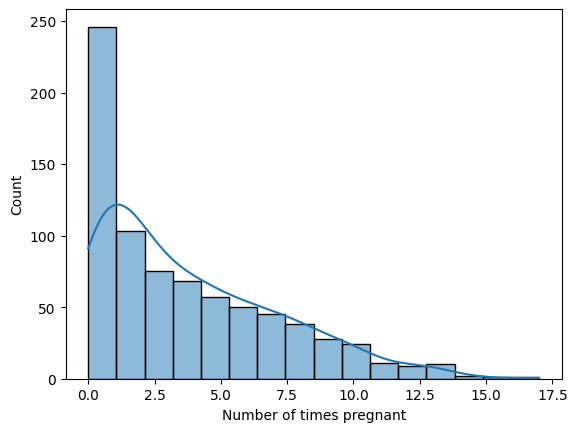

Skewness: 0.9016739791518588
Kurtosis: 0.15921977754746486


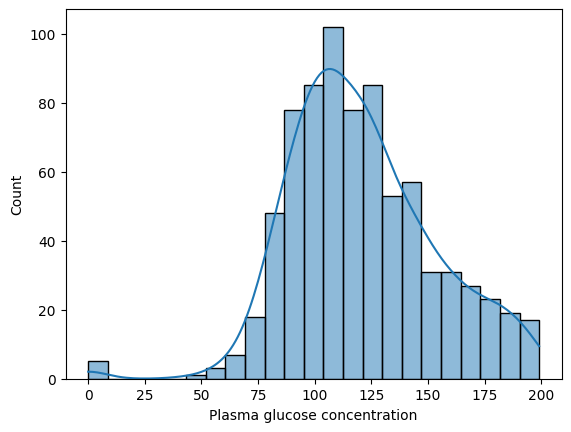

Skewness: 0.17375350179188992
Kurtosis: 0.6407798203735053


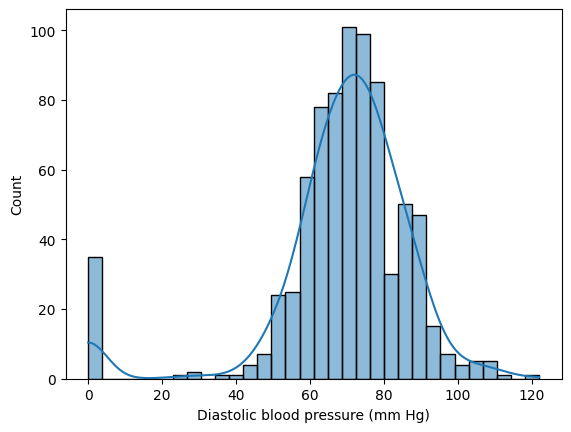

Skewness: -1.8436079833551302
Kurtosis: 5.180156560082496


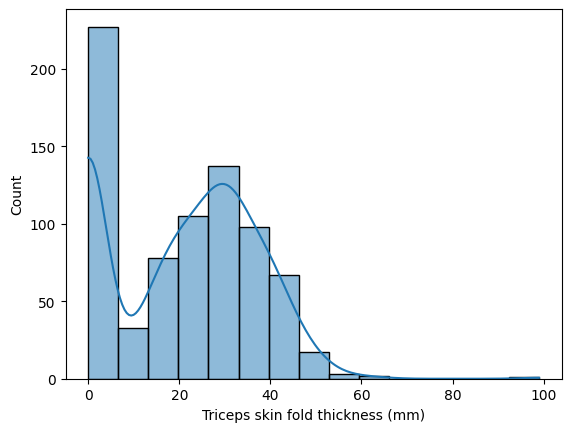

Skewness: 0.10937249648187608
Kurtosis: -0.520071866153013


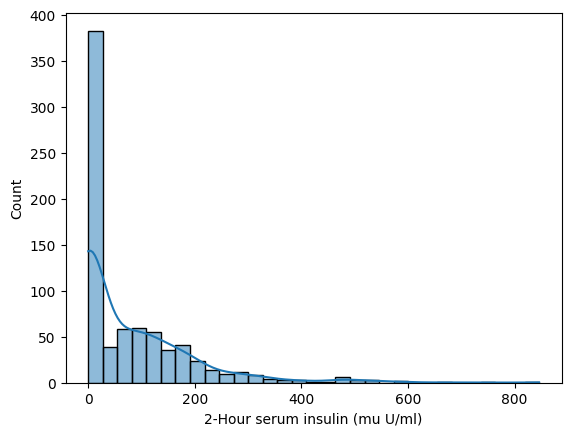

Skewness: 2.272250858431574
Kurtosis: 7.2142595543487715


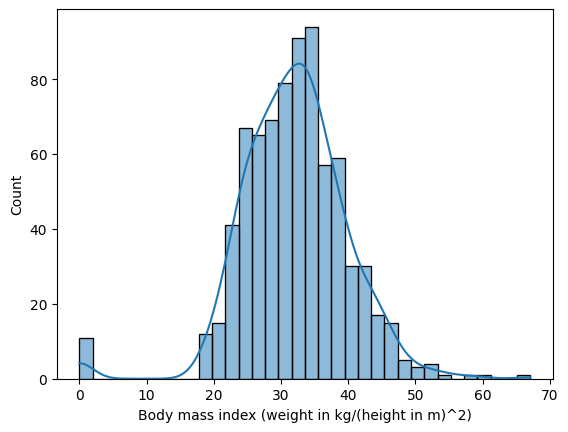

Skewness: -0.42898158845356543
Kurtosis: 3.290442900816981


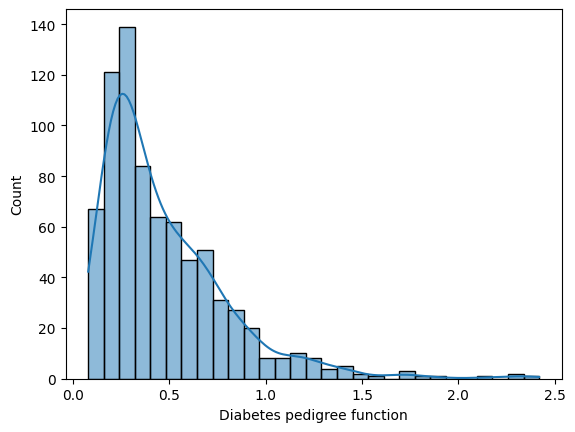

Skewness: 1.919911066307204
Kurtosis: 5.5949535279830584


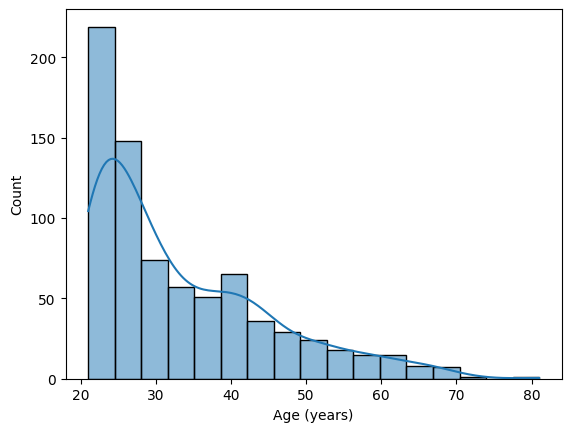

Skewness: 1.1295967011444805
Kurtosis: 0.6431588885398942


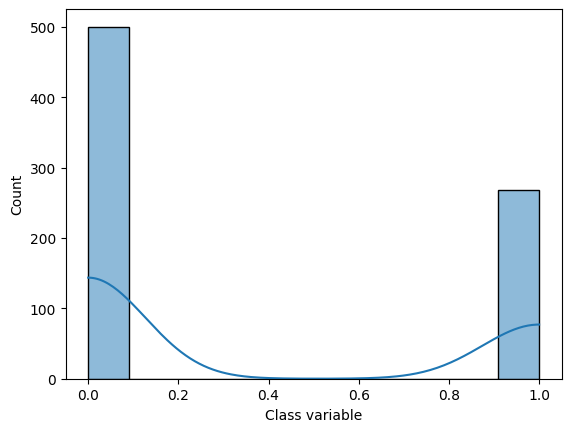

Skewness: 0.635016643444986
Kurtosis: -1.600929755156027


In [521]:
for i in df_dtype_converted.select_dtypes(include='number').columns:
    sns.histplot(data = df_dtype_converted,x= i,kde=True)
    plt.show()
    
    print("Skewness:", df_dtype_converted[i].skew())  # Should be close to 0
    print("Kurtosis:", df_dtype_converted[i].kurt())  # Should be close to 3


## Target Transformation - Regression

In [522]:
from scipy.stats import shapiro, anderson, kstest

def transform_target_check(target, col_name):
    transform_target = False  # Default assumption: No transformation needed

    if len(target) <= 5000:
        # Use Shapiro-Wilk Test for small datasets
        stat, p = shapiro(target)
        print(f"{col_name}: Shapiro-Wilk Test Statistic={stat}, p-value={p}")
        transform_target = p <= 0.05 
        target_transform_report = {
            'Shapiro-Wilk Test Statistic' : stat,
            'Shapiro-Wilk Test p-value' : p
        }
        # If p-value ≤ 0.05, transform target
    else:
        # Use Anderson-Darling Test for large datasets
        result = anderson(target, dist='norm')
        print(f"{col_name}: Anderson-Darling Test Statistic={result.statistic}")

        # Compare the statistic to the 5% critical value
        if result.statistic > result.critical_values[2]:  
            transform_target = True  # If statistic > critical value → Not normal → Transform
        
        # Additional check using Kolmogorov-Smirnov Test
        ks_stat, ks_p = kstest(target, 'norm', args=(target.mean(), target.std()))
        print(f"{col_name}: Kolmogorov-Smirnov Test Statistic={ks_stat}, p-value={ks_p}")
        target_stat,target_p = kp_stat,kp_p
        target_transform_report = {
            'Kolmogorov-Smirnov Test Statistic' : ks_stat,
            'Kolmogorov-Smirnov Test p-value' : ks_p
        }
        if ks_p < 0.05:  # If p-value < 0.05, target is not normal
            transform_target = True

    print(f"Transform Target: {transform_target}")
    return transform_target,target_transform_report




In [523]:
# test
#user_inputs['Machine Learning Task'] = 'Regression'
#user_inputs['Target Column'] = 'PetalLengthCm'
#user_inputs['Machine Learning Task'] = 'Classification'
#user_inputs['Target Column'] = 'Species'

In [524]:
if (user_inputs['Machine Learning Task'] == 'Regression'):
    transform_target_req,target_transform_report = transform_target_check(df_dtype_converted[user_inputs['Target Column']],user_inputs['Target Column'])
    preprocessing_report_inputs['target_transform_report'] = target_transform_report
else:
    transform_target_req = False    

In [525]:
target_p

1.1960502558343857e-36

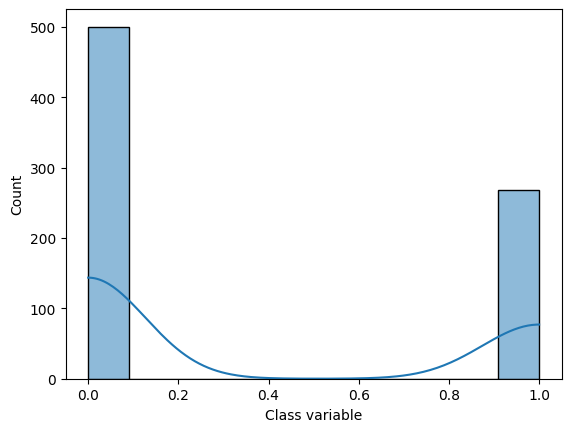

In [526]:
sns.histplot(df_dtype_converted[user_inputs['Target Column']],kde = True)
plt.show()

## Remove Multicollinearity

In [527]:
def multicollinearity_check(df_new):
    corr_matrix = df_new.corr(numeric_only=True)

    # Get the absolute correlation values
    corr_matrix_abs = corr_matrix.abs()

    # Set the diagonal to 0 to ignore self-correlation
    np.fill_diagonal(corr_matrix_abs.values, 0)

    # Check if any correlation coefficient is greater than 0.9
    multicollinearity_req = (corr_matrix_abs > 0.9).any().any()

    print("Multicollinearity detected:", multicollinearity_req)
    
    return multicollinearity_req

multicollinearity_req = multicollinearity_check(df_dtype_converted)

Multicollinearity detected: False


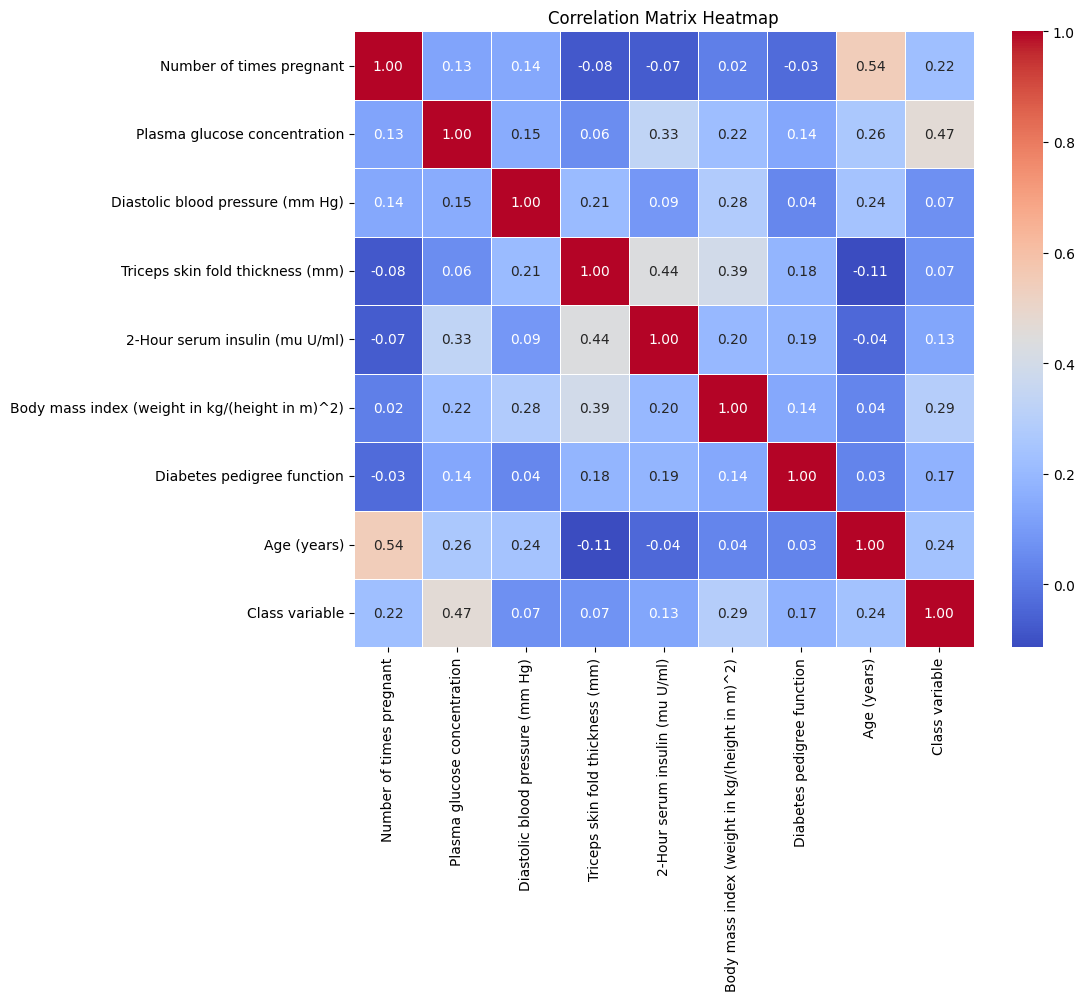

In [528]:
corr_matrix = df_dtype_converted.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

## Outlier

In [529]:

outliers_count = {}
def outliers_iqr_check(df):
    feature_out = []
    lower_out = []
    upper_out = []
    """Detects if any numerical columns contain outliers using IQR."""
    for col in df.select_dtypes(include=['number']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
       
        lower_outliers = df[df[col] < lower_bound]
        upper_outliers = df[df[col] > upper_bound]
        
        feature_out.append(col)
        lower_out.append(len(lower_outliers))
        upper_out.append(len(upper_outliers))
        
    outliers_count = {
            'Feature' : feature_out,
            'Lower_count' : lower_out,
            'Upper_count' : upper_out
        }     
    if sum(lower_out) == 0 & sum(upper_out):
        return True ,outliers_count
    else:# If outliers exist in any column, return True
        return False,outliers_count  # No outliers detected

# Detect outliers in the dataset
outliers_req,outliers_count = outliers_iqr_check(df_dtype_converted.drop(columns=[user_inputs['Target Column']]))
preprocessing_report_inputs['outliers_count'] = outliers_count

In [530]:
outliers_count

{'Feature': ['Number of times pregnant',
  'Plasma glucose concentration',
  'Diastolic blood pressure (mm Hg)',
  'Triceps skin fold thickness (mm)',
  '2-Hour serum insulin (mu U/ml)',
  'Body mass index (weight in kg/(height in m)^2)',
  'Diabetes pedigree function',
  'Age (years)'],
 'Lower_count': [0, 5, 38, 0, 0, 11, 0, 0],
 'Upper_count': [4, 0, 7, 1, 34, 8, 29, 9]}

In [531]:
pd.DataFrame(outliers_count) # Report

,Feature,Lower_count,Upper_count
0,Number of times pregnant,0,4
1,Plasma glucose concentration,5,0
2,Diastolic blood pressure (mm Hg),38,7
3,Triceps skin fold thickness (mm),0,1
4,2-Hour serum insulin (mu U/ml),0,34
5,Body mass index (weight in kg/(height in m)^2),11,8
6,Diabetes pedigree function,0,29
7,Age (years),0,9


In [532]:
#sns.boxplot(data = df_dtype_converted[['age', 'sex', 'bmi', 'children', 'smoker', 'region']])
#plt.show()

## Target Imbalance - Classification

Class Distribution:
Class variable
0    500
1    268
Name: count, dtype: int64
Imbalance Ratio: 1.87


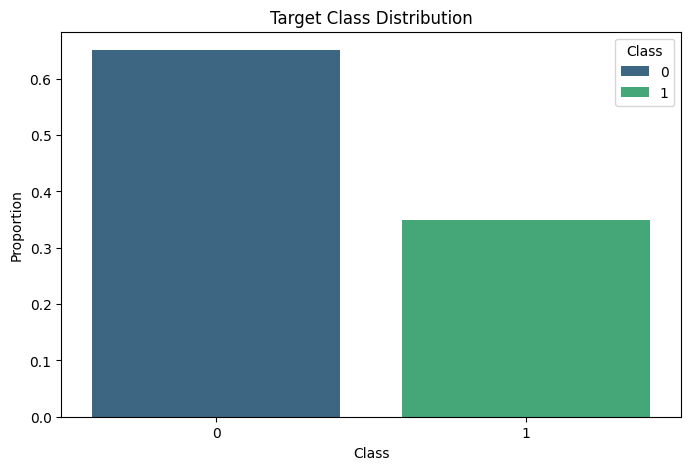

Target Imbalance : False


In [533]:
def target_imbalance_check(df, target_col, threshold=2):
    """Detects imbalance in classification targets"""
    class_counts = df[target_col].value_counts()
    imbalance_ratio = class_counts.max() / class_counts.min()
    
    print(f"Class Distribution:\n{class_counts}")
    print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

    if imbalance_ratio >= threshold:
        target_imbalance_req = True
    else:
        target_imbalance_req = False
    # Visualize class distribution
    class_dist = df[target_col].value_counts(normalize=True).reset_index()
    class_dist.columns = ['Class', 'Proportion']  # Rename columns for readability

    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Class', y='Proportion', data=class_dist, hue = 'Class', palette='viridis')

    plt.title("Target Class Distribution")
    plt.ylabel("Proportion")
    plt.xlabel("Class")
    plt.show()
    
    return target_imbalance_req
    

if user_inputs['Machine Learning Task'] == 'Classification':
    target_imbalance_req = target_imbalance_check(df_dtype_converted, user_inputs['Target Column'])
    preprocessing_report_inputs['target_transform_report'] = None
    print(f'Target Imbalance : {target_imbalance_req}')
    

## Feature Selection

In [534]:
if df_dtype_converted.shape[0] <= df_dtype_converted.shape[1] or df_dtype_converted.shape[1] > 15:
    feature_sele_req = True
else:
    feature_sele_req = False


In [535]:
#data = df_dtype_converted
print(f'Feature Selection Required : {feature_sele_req}')
print(f'Outlier Present : {outliers_req}')
print(f'Multicollinearity Available : {multicollinearity_req}')
print(f'Target Transformation Required : {transform_target_req}')
print(f'Feature Tranformation : {transformation_req}') 
print(f'Feature Normalization: {normalization_req}')
print(f'Feature Imputation Method: {imput_method}') 

Feature Selection Required : False
Outlier Present : False
Multicollinearity Available : False
Target Transformation Required : False
Feature Tranformation : True
Feature Normalization: True
Feature Imputation Method: mean


In [536]:
preprocessing_inputs = {
    'transformation_req': bool(transformation_req),
    'normalization_req': bool(normalization_req),
    'imput_method': imput_method,  # assuming this is already a native type (string, etc.)
    'outliers_req': bool(outliers_req),
    'feature_sele_req': bool(feature_sele_req),
    'multicollinearity_req': bool(multicollinearity_req),
    
}
if user_inputs['Machine Learning Task'] == 'Regression':
    
    preprocessing_inputs['transform_target_req'] = bool(transform_target_req)
    preprocessing_inputs['target_imbalance_req'] = None
    
elif user_inputs['Machine Learning Task'] == 'Classification':
    
    preprocessing_inputs['target_imbalance_req'] = bool(target_imbalance_req)
    preprocessing_inputs['transform_target_req'] = None



assets_folder = "metadata"
os.makedirs(assets_folder, exist_ok=True)
    
json_file_path_prepocess_ip = os.path.join(assets_folder, "preprocessing_inputs.json")
with open(json_file_path_prepocess_ip, 'w') as f:
    json.dump(preprocessing_inputs, f)

In [537]:

json_file_path_prepocess_report_ip = os.path.join(assets_folder, "preprocessing_report_inputs.json")
with open(json_file_path_prepocess_report_ip, 'w') as f:
    json.dump(preprocessing_report_inputs, f,default=str)

In [538]:
preprocessing_inputs 

{'transformation_req': True,
 'normalization_req': True,
 'imput_method': 'mean',
 'outliers_req': False,
 'feature_sele_req': False,
 'multicollinearity_req': False,
 'target_imbalance_req': False,
 'transform_target_req': None}

In [539]:
preprocessing_report_inputs

{'raw_shape': (768, 9),
 'raw_dtype': {'Number of times pregnant': dtype('int64'),
  'Plasma glucose concentration': dtype('int64'),
  'Diastolic blood pressure (mm Hg)': dtype('int64'),
  'Triceps skin fold thickness (mm)': dtype('int64'),
  '2-Hour serum insulin (mu U/ml)': dtype('int64'),
  'Body mass index (weight in kg/(height in m)^2)': dtype('float64'),
  'Diabetes pedigree function': dtype('float64'),
  'Age (years)': dtype('int64'),
  'Class variable': dtype('int64')},
 'Remove_duplicate_shape': (768, 9),
 'col_drop_70_na': (768, 9),
 'na_summary': {'Number of times pregnant': 0,
  'Plasma glucose concentration': 0,
  'Diastolic blood pressure (mm Hg)': 0,
  'Triceps skin fold thickness (mm)': 0,
  '2-Hour serum insulin (mu U/ml)': 0,
  'Body mass index (weight in kg/(height in m)^2)': 0,
  'Diabetes pedigree function': 0,
  'Age (years)': 0,
  'Class variable': 0},
 'impute_graph_data': None,
 'impute_method': 'mean',
 'norm_report': {'scale_ratio': 347.823894725702,
  'range